# Session selection helper for converting dicoms to BIDS nifti.

This is how we select the most recent sessions of the subjects from PPMI and ADNI to get an elder population so that we have better matched control cohort for the local ET cohort.

In [37]:
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd

#PATH
main_dir = Path("/scratch")
out_dir = Path("/output")
code_dir = main_dir / 'ET_biomarker' / 'scripts' / 'heudiconv'
adni_dcm_file = code_dir/ 'heudiconv_res' / 'ADNI_dicomInfo.tsv'  # from dicom headers
ppmi_dcm_file = code_dir/ 'heudiconv_res' / 'PPMI_dicomInfo.tsv'  # from dicom headers
adni_dcm_folder_file = code_dir/ 'heudiconv_res' / 'ADNI_dcm_format4.csv' # from dicom folder names
adni_dl_file = main_dir / 'ET_biomarker' / 'tab_data' / '3T_T1_CN_ADNI2_7_15_2021.csv' # from download page
ppmi_dl_file = main_dir / 'ET_biomarker' / 'tab_data' / '3T_T1_NC_PPMI_5_08_2021.csv'  # from download page
adni_session_file = out_dir / 'ADNI_session.ses' # output: session we are going to process
# Read table
adni_full_data=pd.read_csv(adni_dcm_file, sep='\t')
ppmi_full_data=pd.read_csv(ppmi_dcm_file, sep='\t')
adni_dl_full_data=pd.read_csv(adni_dl_file, sep=',')
ppmi_dl_full_data=pd.read_csv(ppmi_dl_file, sep=',')
adni_folder_data=pd.read_csv(adni_dcm_folder_file, sep='\t',skip_blank_lines=1)

Observed dicom header problems for age,sex and other columns. Need to fix age and sex manually.
The image_id and session id are not the same feature.
http://adni.loni.usc.edu/support/experts-knowledge-base/question/?QID=488
recommend not to use images with 
LONI image 58872 has 2 MPRAGE scans in the single series (332 slices) it fails protocol and image QC since it does not have 166 slices.
We would suggest that you use the MPRAGE Repeat scan LONI I58874 for that subjectâ€™s time-point.
MPRAGE or IR-FSPGR. for T1

In [26]:
pd.set_option('mode.chained_assignment','warn')
dcm_feature_list = ['patient_id','dcm_dir_name','date','series_id', 'sequence_name','series_description', 'protocol_name','dim1','dim2','dim3','dim4']
dl_feature_list = ['Subject','Image Data ID','Description','Acq Date','Sex','Age', 'Visit']

adni_dcm_data = adni_full_data[dcm_feature_list];  ppmi_dcm_data = ppmi_full_data[dcm_feature_list]
adni_dl_data  = adni_dl_full_data[dl_feature_list]; ppmi_dl_data = ppmi_dl_full_data[dl_feature_list]
# check download meta data and dcm information
display('dicom info:',len(adni_dcm_data))
display('download meta data info:',len(adni_dl_data))

'dicom info:'

2284

'download meta data info:'

7320

In [3]:
# Confirmation from dicom folders due to missing information from dicom headers
adni_folder_data=pd.read_csv(adni_dcm_folder_file, sep='\t',skip_blank_lines=1)
adni_folder_data=adni_folder_data.dropna()
adni_folder_data=adni_folder_data.iloc[:,1:]
adni_folder_data=adni_folder_data.rename(columns={"Unnamed: 1": "patient_id", "Unnamed: 2":"series_description", 'Unnamed: 3':"date", "Unnamed: 4":"dcm_dir_name"})
adni_folder_data=adni_folder_data.reset_index()
#adni_folder_data.head()

# confirmation from 
df_tmp=adni_folder_data[(adni_folder_data['series_description'].str.contains('MPRAGE', regex=False)) | \
                        (adni_folder_data['series_description'].str.contains('SPGR', regex=False))]
#adni_dcm_data['dim3'].unique()
display(len(df_tmp['patient_id'].unique()))
display(len(adni_folder_data['patient_id'].unique()))

#adni_full_data[adni_full_data['dim3']>600].tail(5)
tmp_col1=df_tmp.groupby(['patient_id'])
A = tmp_col1['date'].transform(max)
df_tmp.loc[:,'last_session_time']=list(A)
#B
df_tmp = df_tmp[df_tmp['date']==df_tmp['last_session_time']]
#df_tmp['i_id']=df_tmp.index
#display(len(df_tmp))
df_tmp.sort_values(by='patient_id')
gX=df_tmp.groupby('patient_id')
g1X=gX['dcm_dir_name'].apply(lambda x: max(x))
display(g1X)
#g1.to_csv(adni_session_file,header=0)
len(g1X)

index  patient_id series_description                   date dcm_dir_name
0      3  002_S_0295  3_Plane_Localizer  2011-06-02_07_56_57.0      S110472
1      6  002_S_0295      Field_Mapping  2011-06-02_08_29_18.0      S110473
2      9  002_S_0295             MPRAGE  2011-06-02_07_58_50.0      S110476
3     11  002_S_0295             MPRAGE  2012-05-10_15_44_50.0      S150055
4     14  002_S_0295      MPRAGE_SENSE2  2011-06-02_08_08_45.0      S110477

In [18]:
# session information from dicom headers
df_tmp=adni_dcm_data[(adni_dcm_data['dim1']>190) & (adni_dcm_data['dim1']<300) & \
                     (adni_dcm_data['dim2']>190) & (adni_dcm_data['dim2']<300) & \
                     (adni_dcm_data['dim3']>100) & (adni_dcm_data['dim3']<500) & \
                     ((adni_dcm_data['series_description'].str.contains('MPRAGE', regex=False)) | \
                      (adni_dcm_data['series_description'].str.contains('SPGR', regex=False)))]
#display(df_tmp)
#adni_dcm_data['dim3'].unique()
display(len(df_tmp['patient_id'].unique()))
display(len(adni_dcm_data['patient_id'].unique()))
#display(tmp_col)
#adni_full_data[adni_full_data['dim3']>600].tail(5)
tmp_col=df_tmp.groupby(['patient_id'])
B = tmp_col['date'].transform(max)
df_tmp.loc[:,'last_session_time']=list(B)
#B
df_tmp = df_tmp[df_tmp['date']==df_tmp['last_session_time']]
#df_tmp['i_id']=df_tmp.index
#display(len(df_tmp))
df_tmp.sort_values(by='patient_id')
g=df_tmp.groupby('patient_id')
g1=g['dcm_dir_name'].apply(lambda x: max(x))
display(g1)
g1.to_csv(adni_session_file,header=0)
len(g1)
#list(g1)
#adni_dcm_data[adni_dcm_data[] in list(g1)]

223

300

/usr/local/miniconda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/miniconda/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


patient_id
002_S_0295    S110477
002_S_0413    S111992
002_S_0685    S114048
002_S_1280    S183170
002_S_4213    S121168
               ...   
941_S_4100    S418036
941_S_4255    S133770
941_S_4292    S489258
941_S_4365    S437573
941_S_4376    S437610
Name: dcm_dir_name, Length: 223, dtype: object

223

In [38]:
g1.to_csv(adni_session_file,header=0)
display(g1.index)
g1.loc[g1.index[0]]
for x in g1.index:
    f_path = out_dir / 'ADNI_sessions'  / x
    f = open(f_path, "w")
    f.write(g1.loc[x])
    f.close()

Index(['002_S_0295', '002_S_0413', '002_S_0685', '002_S_1280', '002_S_4213',
       '002_S_4225', '002_S_4264', '003_S_0907', '003_S_0981', '003_S_4081',
       ...
       '153_S_4151', '941_S_1195', '941_S_1202', '941_S_1203', '941_S_4066',
       '941_S_4100', '941_S_4255', '941_S_4292', '941_S_4365', '941_S_4376'],
      dtype='object', name='patient_id', length=223)

In [20]:
# check all 'SPGR' sequences
sequence_names = adni_dcm_data['series_description'].unique()
for x in sequence_names:
    if 'SPGR' in x:
        print(x)
# check all 'MPRAGE' sequences
sequence=adni_dcm_data['series_description'].unique()
for x in sequence:
    if 'MPRAGE' in x:
        print(x)

IR-FSPGR
IR-FSPGR-Repeat
IR-FSPGR REPEAT
IR-SPGR w/acceleration
Accelerated Sag IR-SPGR
Sag IR-SPGR
Sag IR-FSPGR
Accelerated SAG IR-SPGR
IR-SPGR
IR-FSPGR (replaces MP-Rage)
SAG IR-FSPGR
Accelerated Sag IR-FSPGR
Accelerated SAG IR-SPGR REPEAT
Accelerated SAG IR-FSPGR
Sag IR-FSPGR Repeat
SAG IR-FSPGR-Repeat


'dicom info:'

2284

'download meta data info:'

7320

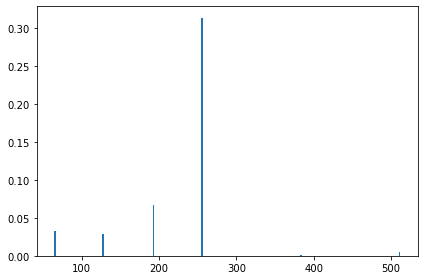

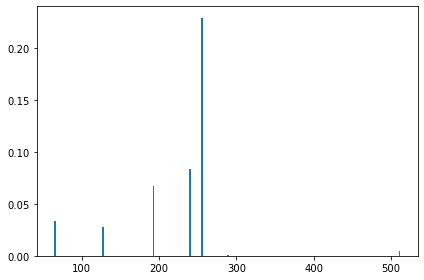

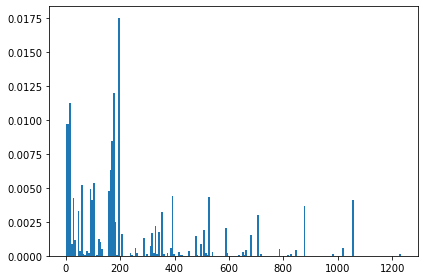

In [17]:
# check ordered subjects
#display(ppmi_dl_data.sort_values(by='Subject', ascending=False).head())
#display(ppmi_dcm_data.sort_values(by='patient_id', ascending=False).head())
import seaborn as sns
import matplotlib.pyplot as plt

# the histogram of the data
fig, ax = plt.subplots()
n, bins, patches = ax.hist(adni_dcm_data['dim1'], 200, density=True)
# add a 'best fit' line
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()
fig, ax = plt.subplots()
n, bins, patches = ax.hist(adni_dcm_data['dim2'], 200, density=True)
# add a 'best fit' line
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()
fig, ax = plt.subplots()
n, bins, patches = ax.hist(adni_dcm_data['dim3'], 200, density=True)
# add a 'best fit' line
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

#sns.set_theme(style="darkgrid")
#sns.displot(
#    adni_dcm_data, x="dim3", row="series_description",
#    binwidth=3, height=3, facet_kws=dict(margin_titles=True),)

In [ ]:
tmp_col=adni_data.groupby(['patient_id'])
B = tmp_col['date'].transform(max)
adni_data.loc[:,'last_session_time']=list(B)
#B
adni_data = adni_data.loc[adni_data['date']==adni_data['last_session_time']]
adni_data

a=ppmi_full_data.loc[:,'patient_id'].unique()
a.sort()
len(a)

In [ ]:
b=ppmi_dl_full_data.loc[:,'Subject'].unique()
b.sort()
len(b)